<a href="https://colab.research.google.com/github/WennieLin/solar_flare_model/blob/main/solar_flare_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # use imbalanced-learn's pipeline

In [11]:
from sklearn.ensemble import RandomForestClassifier  # Add this import at the top if it's not already included

# Load dataset
df = pd.read_csv("data/SolarFlareDataset.csv")

# Remove class with only one instance (class 2) to allow stratified splitting
df = df[df["severe flares"] != 2]

# Define features and target
X = df.drop(columns=["severe flares"])
y = df["severe flares"]

# Define column types
ordinal_cols = ["modified Zurich class", "largest spot size"]  # Ordered categories
nominal_cols = ["spot distribution"]  # Unordered category
numerical_cols = [col for col in X.columns if col not in ordinal_cols + nominal_cols]

# Create transformers
ordinal_transformer = OrdinalEncoder()
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols),
        ('num', numerical_transformer, numerical_cols)
    ]
)

# Split data (stratify for imbalanced classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models and parameters
models = {
    'Ridge': {
        'model': RidgeClassifier(),
        'params': {'model__alpha': [0.1, 1.0, 10.0]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'model__n_neighbors': [3, 5, 7]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 150],
            'model__max_depth': [5, 10, None]
        }
    }
}

results = {}
# Run GridSearchCV with SMOTE inside the pipeline
for name, config in models.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', config['model'])
    ])

    grid = GridSearchCV(pipeline, config['params'], cv=5)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    results[name] = {
        'best_params': grid.best_params_,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }

# Show evaluation results
results_df = pd.DataFrame({k: v['report']['weighted avg'] for k, v in results.items()}).T.round(3)
print("📊 Model Evaluation (Weighted Average Metrics):")
print(results_df)

# Show best hyperparameters
for model_name, res in results.items():
    print(f"\n🔧 Best parameters for {model_name}: {res['best_params']}")

# Display results in a clean format
results_df = pd.DataFrame({k: v['report']['weighted avg'] for k, v in results.items()}).T.round(3)
print("Model Evaluation (Weighted Average Metrics):")
print(results_df)

# Optional: Show best parameters
for model_name, res in results.items():
    print(f"\nBest parameters for {model_name}: {res['best_params']}")

# Select numerical features + target
numerical_df = df[numerical_cols + ['severe flares']]


📊 Model Evaluation (Weighted Average Metrics):
              precision  recall  f1-score  support
Ridge             0.993   0.835     0.903    278.0
KNN               0.985   0.960     0.973    278.0
RandomForest      0.986   0.993     0.989    278.0

🔧 Best parameters for Ridge: {'model__alpha': 0.1}

🔧 Best parameters for KNN: {'model__n_neighbors': 3}

🔧 Best parameters for RandomForest: {'model__max_depth': 10, 'model__n_estimators': 100}
Model Evaluation (Weighted Average Metrics):
              precision  recall  f1-score  support
Ridge             0.993   0.835     0.903    278.0
KNN               0.985   0.960     0.973    278.0
RandomForest      0.986   0.993     0.989    278.0

Best parameters for Ridge: {'model__alpha': 0.1}

Best parameters for KNN: {'model__n_neighbors': 3}

Best parameters for RandomForest: {'model__max_depth': 10, 'model__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


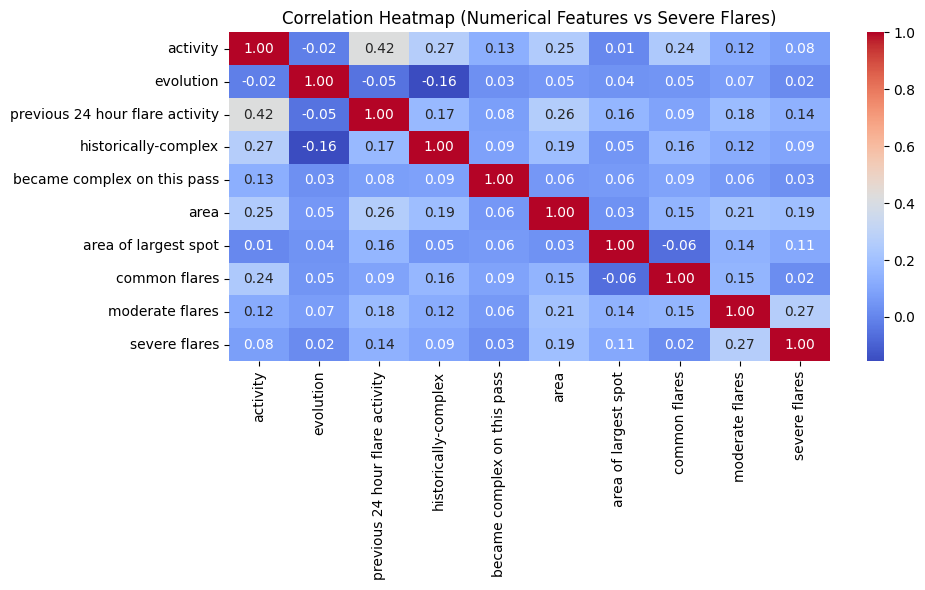

In [12]:

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
corr = numerical_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features vs Severe Flares)")
plt.tight_layout()
plt.show()

<ipython-input-13-41b320844a4f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


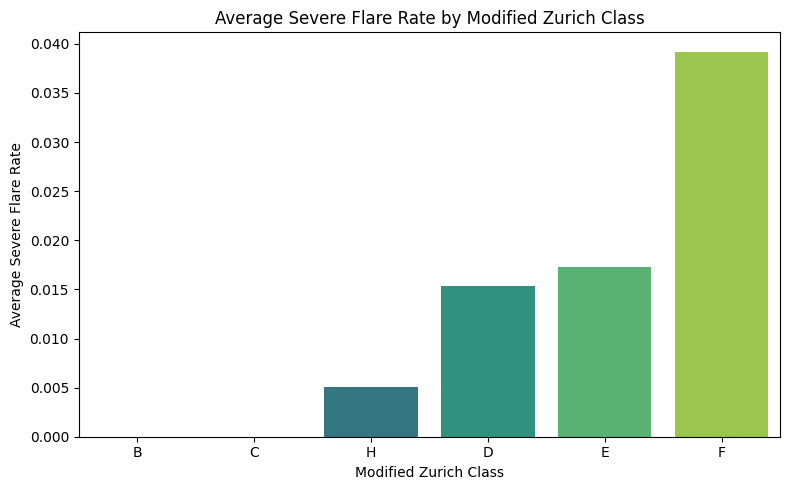

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Modified Zurich Class and compute the mean severe flare rate
severe_rate_by_zurich = df.groupby("modified Zurich class")["severe flares"].mean().sort_values()

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=severe_rate_by_zurich.index,
    y=severe_rate_by_zurich.values,
    palette="viridis"
)
plt.title("Average Severe Flare Rate by Modified Zurich Class")
plt.xlabel("Modified Zurich Class")
plt.ylabel("Average Severe Flare Rate")
plt.tight_layout()
plt.show()

🔍 Weighted Average Precision, Recall, F1-Score for Each Model:


,precision,recall,f1-score,support
Ridge,0.993,0.835,0.903,278.0
KNN,0.985,0.960,0.973,278.0
RandomForest,0.986,0.993,0.989,278.0


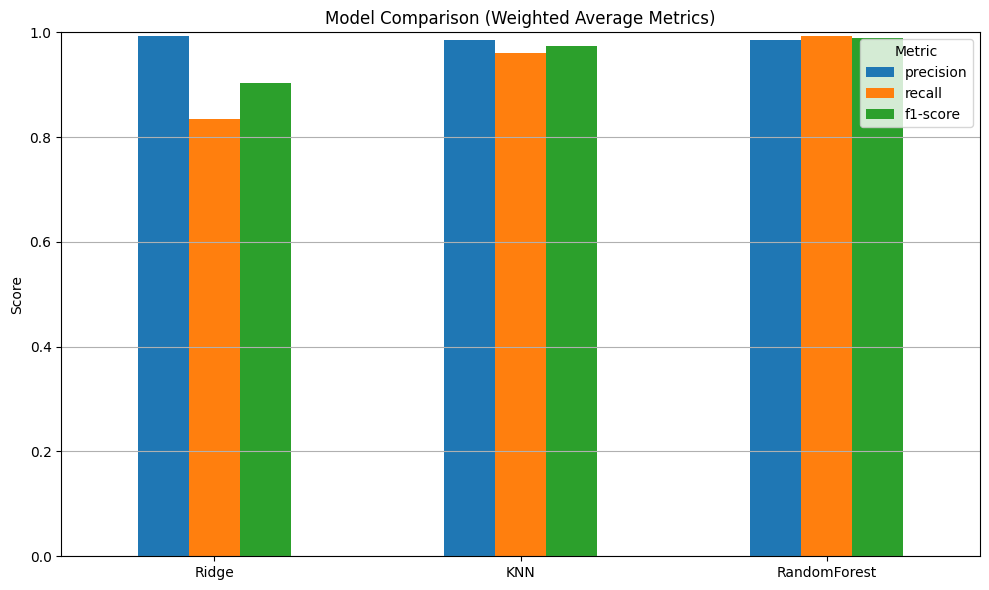

In [14]:
# Show performance metrics table
print("🔍 Weighted Average Precision, Recall, F1-Score for Each Model:")
display(results_df)

# Plot comparison bar chart
metrics = ['precision', 'recall', 'f1-score']
results_df[metrics].plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison (Weighted Average Metrics)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()